In [1]:
%matplotlib inline

In [129]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [678]:
from scipy import ndimage as ndi

In [639]:
from skimage import data, io, filters, color, segmentation, exposure, measure, morphology
from skimage.segmentation import felzenszwalb, slic, quickshift, random_walker
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float, img_as_int
from skimage.future import graph
from skimage.feature import hog
from skimage.morphology import reconstruction
from skimage.filters import rank
from skimage.morphology import disk

# Segmentation experiments

In [112]:
img = io.imread('data/2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001.tif')
img = img_as_float(img)

## References

- [Segmentation routines in skimage](http://scikit-image.org/docs/dev/api/skimage.segmentation.html)
- [Regional adjacency graphs in skimage](http://scikit-image.org/docs/dev/api/skimage.graph.html)

## Original image

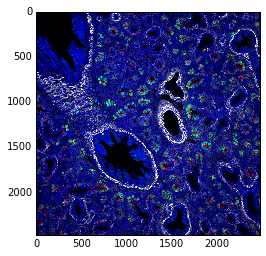

In [113]:
plt.imshow(img)
pass

## Image region to segment

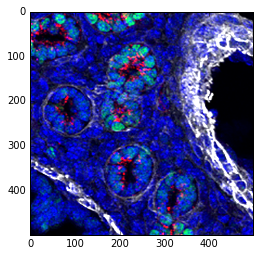

In [369]:
im1 = img[1000:1500, 1000:1500]
plt.imshow(im1)
pass

## Segmenting in gray scale

In [540]:
im2 = color.rgb2grey(im1)

### Using Histogram of Gradients

In [541]:
fd, hog_image = hog(im2, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0.0, 0.08))

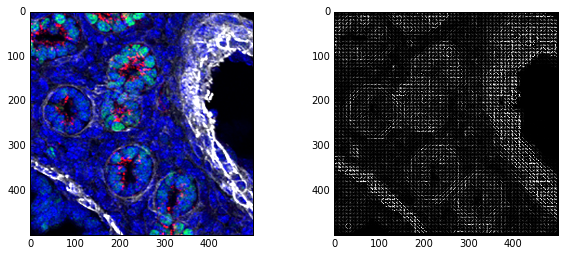

In [542]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].imshow(im1)
axes[1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
pass

### Convert features to binary

In [574]:
selem = disk(20)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilateral_result = rank.mean_bilateral(hog_image_rescaled, selem=selem, s0=250, s1=250)

In [534]:
markers = np.zeros(bilateral_result.shape, dtype=np.uint)
markers[bilateral_result < 5] = 1
markers[(bilateral_result >= 10) & (bilateral_result < 20)] = 2
markers[(bilateral_result >= 20) & (bilateral_result < 256)] = 3

labels = random_walker(bilateral_result, markers, beta=10, mode='bf')

In [643]:
p2, p98 = np.percentile(bilateral_result, (5, 95))
img_rescale = exposure.rescale_intensity(bilateral_result, in_range=(p2, p98))
img_adapteq = exposure.equalize_adapthist(bilateral_result, clip_limit=0.03)

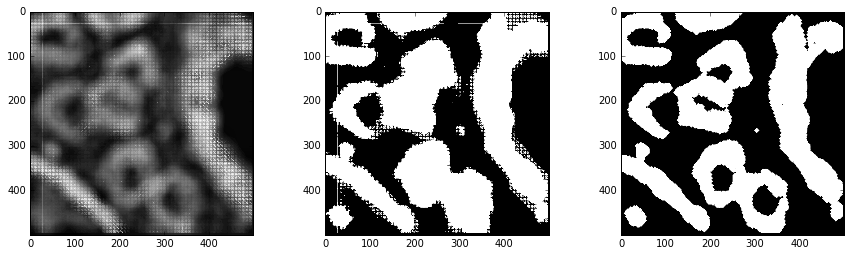

In [679]:
image = img_adapteq.copy()
threshold = filters.threshold_li(image)
img_binary = image > threshold

filled = ndi.binary_fill_holes(img_binary)

k = 5
img_binary2 = img_binary.copy()
for i in range(k):
    img_binary2 = morphology.erosion(img_binary2)
for i in range(k):
    img_binary2 = morphology.dilation(img_binary2)

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].imshow(img_adapteq, cmap=plt.cm.gray)
axes[1].imshow(filled, cmap=plt.cm.gray)
axes[2].imshow(img_binary2, cmap=plt.cm.gray)
pass

### Find contours of objects

In [641]:
contours1 = measure.find_contours(bilateral_result, np.median(bilateral_result))
contours2 = measure.find_contours(img_rescale, np.median(img_rescale))
contours3 = measure.find_contours(img_adapteq, np.median(img_adapteq))

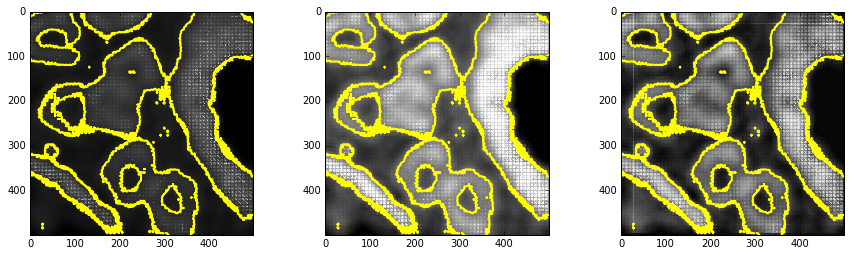

In [642]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
for n, contour in enumerate(contours1):
    axes[0].plot(contour[:, 1], contour[:, 0], color=(1,1,0), linewidth=2)
axes[0].imshow(bilateral_result, cmap=plt.cm.gray)
for n, contour in enumerate(contours2):
    axes[1].plot(contour[:, 1], contour[:, 0], color=(1,1,0), linewidth=2)
axes[1].imshow(img_rescale, cmap=plt.cm.gray)
for n, contour in enumerate(contours2):
    axes[2].plot(contour[:, 1], contour[:, 0], color=(1,1,0), linewidth=2)
axes[2].imshow(img_adapteq, cmap=plt.cm.gray)
pass

## Segmenting in color

### Segmentation with k-means 

#### Breaking into cell-sized segments

Number of segments: 511


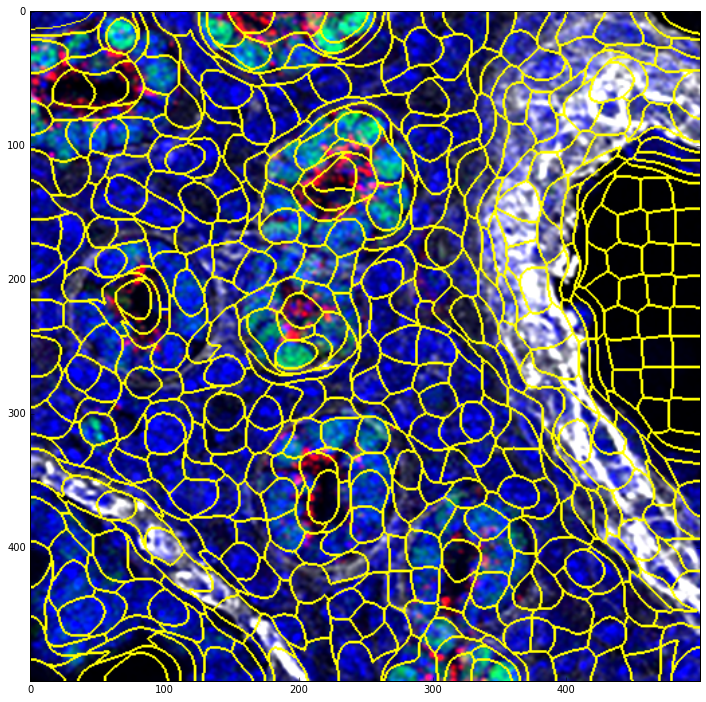

In [210]:
w, h, d = im1.shape
cell_area = 500
n_segments = int(w*h/cell_area)
segments = slic(im1, n_segments=n_segments, compactness=10, sigma=10, 
                multichannel=True, convert2lab=True)
print("Number of segments: %d" % len(np.unique(segments)))
plt.figure(figsize=(12,12))
plt.imshow(mark_boundaries(im1, segments))
pass

### Segmentation with quick shift

Number of segments: 317


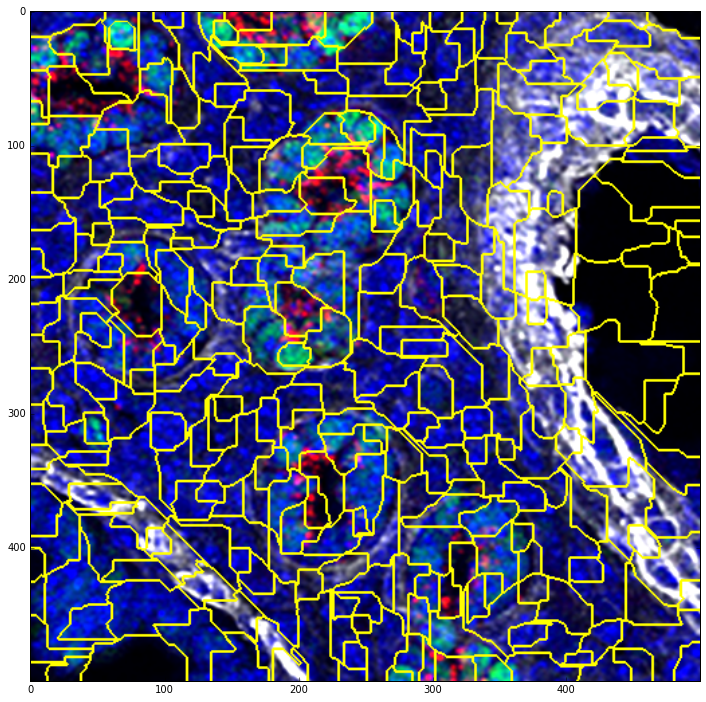

In [222]:
segments = quickshift(im1, kernel_size=2, sigma=10, max_dist=500, ratio=1, convert2lab=True)
print("Number of segments: %d" % len(np.unique(segments)))
plt.figure(figsize=(12,12))
plt.imshow(mark_boundaries(im1, segments))
pass

### Combining segments using cut thresholds

Number of original segments: 511
Number of combined segments: 247


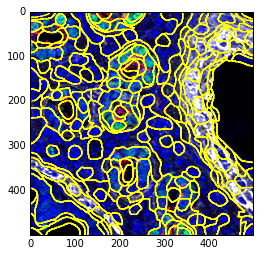

In [307]:
w, h, d = im1.shape
cell_area = 500
n_segments = int(w*h/cell_area)
labels1 = slic(im1, n_segments=n_segments, compactness=10, sigma=10, 
               multichannel=True, convert2lab=True)
out1 = color.label2rgb(labels1, im1, kind='avg')
g = graph.rag_mean_color(im1, labels1)
wts = np.array([g.get_edge_data(u, v)['weight'] for u, v in g.edges()])
labels2 = graph.cut_threshold(labels1, g, thresh=np.mean(wts)/2)
out2 = color.label2rgb(labels2, im1, kind='avg')
print("Number of original segments: %d" % len(np.unique(labels1)))
print("Number of combined segments: %d" % len(np.unique(labels2)))
plt.imshow(mark_boundaries(im1, labels2, outline_color=(1, 1, 0)))
pass

### Combining segments using normalized cut thresholds

Number of original segments: 511
Number of combined segments: 40


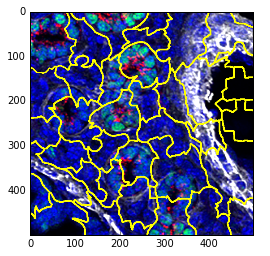

In [323]:
w, h, d = im1.shape
cell_area = 500
n_segments = int(w*h/cell_area)
labels1 = slic(im1, n_segments=n_segments, compactness=10, sigma=10, 
               multichannel=True, convert2lab=True)
out1 = color.label2rgb(labels1, im1, kind='avg')
g = graph.rag_mean_color(im1, labels1)
wts = np.array([g.get_edge_data(u, v)['weight'] for u, v in g.edges()])
labels2 = graph.cut_normalized(labels1, g, thresh=0.25, num_cuts=10)
out2 = color.label2rgb(labels2, im1, kind='avg')
print("Number of original segments: %d" % len(np.unique(labels1)))
print("Number of combined segments: %d" % len(np.unique(labels2)))
plt.imshow(mark_boundaries(im1, labels2, outline_color=(1, 1, 0)))
pass

### Combining segments using hierarchical merge

In [302]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    weight : float
        The absolute difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return diff

In [303]:
def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

#### Merge of k-means segmentation

Number of segments: 81


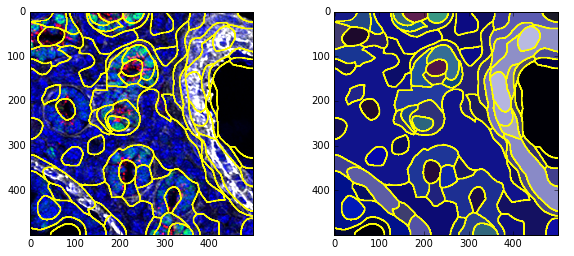

In [310]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    im1 = img_as_int(im1)
    
w, h, d = im1.shape
cell_area = 500
n_segments = int(w*h/cell_area)
labels1 = slic(im1, n_segments=n_segments, compactness=10, sigma=10, 
               multichannel=True, convert2lab=True)

g = graph.rag_mean_color(im1, labels)
wts = np.array([g.get_edge_data(u, v)['weight'] for u, v in g.edges()])
labels2 = graph.merge_hierarchical(labels, g, thresh=np.mean(wts)/2, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
g2 = graph.rag_mean_color(im1, labels2)
out = color.label2rgb(labels2, im1, kind='avg')
out = mark_boundaries(out, labels2, (0, 0, 0))
print("Number of segments: %d" % len(np.unique(labels2)))
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].imshow(mark_boundaries(img_as_float(im1), labels2, outline_color=(1, 1, 0)))
axes[1].imshow(mark_boundaries(out, labels2, outline_color=(1, 1, 0)))
pass

#### Merge of quick shift segmentation

Number of segments: 56


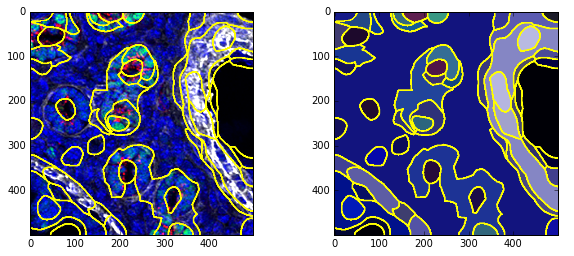

In [311]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    im1 = img_as_int(im1)
    
labels1 = quickshift(im1, kernel_size=2, sigma=10, max_dist=500, ratio=1, convert2lab=True)

g = graph.rag_mean_color(im1, labels)
wts = np.array([g.get_edge_data(u, v)['weight'] for u, v in g.edges()])

labels2 = graph.merge_hierarchical(labels, g, thresh=4000, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
g2 = graph.rag_mean_color(im1, labels2)
out = color.label2rgb(labels2, im1, kind='avg')
out = mark_boundaries(out, labels2, (0, 0, 0))
print("Number of segments: %d" % len(np.unique(labels2)))
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].imshow(mark_boundaries(img_as_float(im1), labels2, outline_color=(1, 1, 0)))
axes[1].imshow(mark_boundaries(out, labels2, outline_color=(1, 1, 0)))
pass